In [17]:
"""code in this notebook adapted from MATLAB code by W.B. 
https://www.wilmabainbridge.com/memorydrawings.html"""

# Enable auto-reload of modified python files.
%load_ext autoreload
%autoreload 2

# packages 
import warnings
import settings
from ast import literal_eval
import os
import re as re
import pandas as pd
import numpy as np
import math
from scipy.spatial import distance
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# helper functions 
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

def clean_image_name(filename):
    return re.findall(r"(.*)\.", filename)[0]

def list_images(IMG_DIRECTORY, img_type):
    image_list = []
    for filename in os.listdir(IMG_DIRECTORY):
        if filename.endswith(img_type):
            image_list.append(clean_image_name(filename))
    return image_list

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# load in the drawings 
data = pd.read_csv(settings.DATA_PATH + '/drawings.csv')

### add in the corners for each drawing
# double-check the corners sizes, will print any rows where corners were not inputed in the right order
corners = pd.read_csv(settings.DATA_PATH + '/corners.csv')
corners['0'] = corners['0'].apply(lambda x: literal_eval(str(x)))
corners['1'] = corners['1'].apply(lambda x: literal_eval(str(x)))
corners['2'] = corners['2'].apply(lambda x: literal_eval(str(x)))
corners['3'] = corners['3'].apply(lambda x: literal_eval(str(x)))
for index, row in corners.iterrows():
    if row['1'][0] < row['1'][1]:
        print ('wrong corners!', row)
    if row['2'][0] > row['2'][1]:
        print('wrong corners!', row)
    if row['0'][0]  > row['3'][0]:
        print('wrong corners!', row)
    if row['0'][1] > row['3'][1]:
        print('wrong corners!', row)
        
#make blank dataframe 
adjusted_sizes = pd.DataFrame()

### scale data! width, height
imdisplaysize = (667, 500)

# scale ellipse
imw = 1280
imh = 960 

conditions = ['search', 'memorize']

# basically just need to scale the data I think....
for condition in conditions:
    # get the csv of all the corners
    # set the directory for the drawings
    if condition == 'search':
        curr_corners = corners[corners['condition'] =='search']
        drawing_dir =  settings.DRAWINGS_PATH + '/search/'
        curr_data = data[data['condition'] == 'search']
    elif condition == 'memorize':
        curr_corners = corners[corners['condition'] =='memorize']
        drawing_dir = settings.DRAWINGS_PATH + '/memorize/'
        curr_data = data[data['condition'] == 'memorize']
    
    # set each column of corners as tuples for x,y
    curr_corners['0'] = curr_corners['0'].apply(lambda x: literal_eval(str(x)))
    curr_corners['1'] = curr_corners['1'].apply(lambda x: literal_eval(str(x)))
    curr_corners['2'] = curr_corners['2'].apply(lambda x: literal_eval(str(x)))
    curr_corners['3'] = curr_corners['3'].apply(lambda x: literal_eval(str(x)))
    
    # go by each image
    for image_name in list_images(settings.IMG_PATH, '.png'):
        curr_im_df = curr_data.loc[curr_data["image_name"]==image_name]

        # loop through subjects that drew this image
        for sub in curr_im_df.drawing_name.unique():
            curr_sub_df = curr_im_df.loc[curr_im_df["drawing_name"]== sub]

            curr_corners_df = curr_corners.loc[curr_corners["ID"] == sub]

            # get the corners for that drawing
            topleft = curr_corners_df.iloc[0,0]
            topright = curr_corners_df.iloc[0,1]
            bottomleft = curr_corners_df.iloc[0,2]
            bottomright = curr_corners_df.iloc[0,3]

            # get the width/height from the corners of the drawing
            scaledwidth = np.mean([topright[0], bottomright[0]]) - np.mean([topleft[0], bottomleft[0]])
            scaledheight = np.mean([bottomright[1], bottomleft[1]]) - np.mean([topright[1], topleft[1]])
                        
            # read in the drawing and get the shape
            curr_draw = plt.imread(str(drawing_dir) + sub + '.jpg')
            draww = curr_draw.shape[1]
            drawh = curr_draw.shape[0]

            #scale x and y 
            scalex  = draww/imdisplaysize[0]
            scaley = drawh/imdisplaysize[1]

            # where the corners would have been based on the scale of the AMT task
            topleft = [topleft[0]/scalex, topleft[1]/scaley]
            topright = [topright[0]/scalex, topright[1]/scaley]
            bottomleft = [bottomleft[0]/scalex, bottomleft[1]/scaley]
            bottomright = [bottomright[0]/scalex, bottomright[1]/scaley]

            # scaling the drawing width and height based on the scale of the AMT task
            scaledwidth = scaledwidth/scalex
            scaledheight = scaledheight/scaley

            for obj in curr_sub_df.object_name.unique():
            # get the median cx, cy, rx, ry from the AMT data, 
            # and then substract the mean of the scaled corners
                curr_obj_df = curr_sub_df.loc[curr_sub_df["object_name"] == obj]

                # scale the ellipse points
                medcx = float(curr_obj_df["drawn_cx"])
                medcy = float(curr_obj_df["drawn_cy"])
                medrx = float(curr_obj_df["drawn_rx"])
                medry = float(curr_obj_df["drawn_ry"])

                medcx = medcx - np.mean([topleft[0], bottomleft[0]])
                medcy = medcy - np.mean([topright[1], topleft[1]])

               # the scale factor is the image width / drawing width scaled by the AMT task
                scalefactorx = imw/scaledwidth
                scalefactory = imh/scaledheight
                medcx = medcx * scalefactorx
                medcy = medcy * scalefactory
                medrx = medrx * scalefactorx
                medry = medry * scalefactory

                # then get the real locations from the image data
                realcx = float(curr_obj_df["img_cx"])
                realcy = float(curr_obj_df["img_cy"])
                realrx = float(curr_obj_df["img_rx"])
                realry = float(curr_obj_df["img_ry"])
                
                # append to list probably?
                cxdiff = medcx-realcx
                cydiff = medcy-realcy
                rxdiff = medrx-realrx
                rydiff = medry-realry

                # append df drawing name, subject name, image name, adrjustedcx = medcx

                adjusted_sizes = adjusted_sizes.append(pd.DataFrame({'condition':[condition],
                                'image_name':[image_name], 
                                  'drawing_name': [sub],
                                  'object_name': [obj],
                                'identity': list(curr_obj_df["identity"]),
                                  'adj_cx': [medcx], 
                                  'adj_cy': [medcy],
                                 'adj_rx': [medrx], 
                                 'adj_ry': [medry], 
                                  'img_cx':[realcx],
                                    'img_cy':[realcy],  
                                    'img_rx':[realrx],
                                    'img_ry':[realry],
                                 'cx_diff': [cxdiff],
                                 'cy_diff': [cydiff],
                                 'rx_diff': [rxdiff],
                                 'ry_diff': [rydiff]}))

# get the absolute differences
adjusted_sizes["cx_diff"] = abs(adjusted_sizes["cx_diff"])
adjusted_sizes["cy_diff"] = abs(adjusted_sizes["cy_diff"])
adjusted_sizes["rx_diff"] = adjusted_sizes["rx_diff"]
adjusted_sizes["ry_diff"] = adjusted_sizes["ry_diff"]

# get the proportional differences
adjusted_sizes["prop_cx"] = (adjusted_sizes["cx_diff"]/imw) * 100
adjusted_sizes["prop_cy"] = (adjusted_sizes["cy_diff"]/imh) * 100 
adjusted_sizes["prop_rx"] = (adjusted_sizes["rx_diff"]/imw) * 100
adjusted_sizes["prop_ry"] = (adjusted_sizes["ry_diff"]/imh) * 100 

adjusted_sizes["participant"] = adjusted_sizes["drawing_name"].str.split('_', 1, expand=True)[0]
adjusted_sizes = adjusted_sizes[adjusted_sizes['adj_rx'].notnull()]

In [19]:
# target size stats search condition
search_tar_sizes = adjusted_sizes.loc[(adjusted_sizes["condition"] == 'search') & (adjusted_sizes["identity"] == 'target')]
search_tar_sizes = search_tar_sizes.loc[search_tar_sizes["image_name"] != 'a-pr23']
search_tar_sizes["img_size"] = search_tar_sizes["img_rx"] * search_tar_sizes["img_ry"] * math.pi
search_tar_sizes["drawn_size"] = search_tar_sizes["adj_rx"] * search_tar_sizes["adj_ry"] * math.pi

print('search tar rx mean:', search_tar_sizes.groupby('image_name').mean()['prop_rx'].mean())
print('search tar rx std:', search_tar_sizes.groupby('image_name').mean()['prop_rx'].std())
print('search tar ry mean:', search_tar_sizes.groupby('image_name').mean()['prop_ry'].mean())
print('search tar ry std:', search_tar_sizes.groupby('image_name').mean()['prop_ry'].std())

result= stats.wilcoxon(x= search_tar_sizes.groupby('image_name').mean()["img_size"].round(0),y = search_tar_sizes.groupby('image_name').mean()["drawn_size"].round(0), method='approx')
print('drawn vs img size target: z =', result.zstatistic, 'p =', result.pvalue)

search tar rx mean: 4.556731683585398
search tar rx std: 2.180694431618191
search tar ry mean: 5.872336965431787
search tar ry std: 1.7580033615776245
drawn vs img size target: z = -3.2957653080153086 p = 0.0009815397525216685


In [20]:
# non-target stats search condition
search_nontar_sizes = adjusted_sizes.loc[(adjusted_sizes["condition"] == 'search') & (adjusted_sizes["identity"] != 'target')]
search_nontar_sizes = search_nontar_sizes.loc[search_nontar_sizes["image_name"] != 'a-pr23']

print('search non-tar rx mean:', search_nontar_sizes.groupby('image_name').mean()['prop_rx'].mean())
print('search non-tar rx std:', search_nontar_sizes.groupby('image_name').mean()['prop_rx'].std())
print('search non-tar ry mean:', search_nontar_sizes.groupby('image_name').mean()['prop_ry'].mean())
print('search non-tar ry std:', search_nontar_sizes.groupby('image_name').mean()['prop_ry'].std())

print('tar vs. non-tar width:', stats.ranksums(search_nontar_sizes.groupby('image_name').mean().sort_values(by="image_name")['prop_rx'], 
               search_tar_sizes.groupby('image_name').mean().sort_values(by="image_name")['prop_rx']))
print('tar vs. non-tar height:', stats.ranksums(search_nontar_sizes.groupby('image_name').mean().sort_values(by="image_name")['prop_ry'], 
               search_tar_sizes.groupby('image_name').mean().sort_values(by="image_name")['prop_ry']))

search non-tar rx mean: 3.8445808475318977
search non-tar rx std: 1.9740460318577069
search non-tar ry mean: 4.937843923552871
search non-tar ry std: 2.36470024296566
tar vs. non-tar width: RanksumsResult(statistic=-0.5054244807092461, pvalue=0.6132607280784302)
tar vs. non-tar height: RanksumsResult(statistic=-1.1486920016119229, pvalue=0.2506830051161011)


In [5]:
# target size stats memorize condition
mem_tar_sizes = adjusted_sizes.loc[(adjusted_sizes["condition"] == 'memorize') & (adjusted_sizes["identity"] == 'target')]
mem_tar_sizes = mem_tar_sizes.loc[mem_tar_sizes["image_name"] != 'a-pr23']

print('mem tar rx mean:', mem_tar_sizes.groupby('image_name').mean()['prop_rx'].mean())
print('mem tar rx std:', mem_tar_sizes.groupby('image_name').mean()['prop_rx'].std())
print('mem tar ry mean:', mem_tar_sizes.groupby('image_name').mean()['prop_ry'].mean())
print('mem tar ry std:', mem_tar_sizes.groupby('image_name').mean()['prop_ry'].std())

print("mem rx tar vs. search:", stats.ranksums(mem_tar_sizes.groupby('image_name').mean().sort_values(by="prop_rx")['prop_rx'], 
               search_tar_sizes.groupby('image_name').mean().sort_values(by="prop_rx")['prop_rx']))
print("mem ry tar vs. search:", stats.ranksums(mem_tar_sizes.groupby('image_name').mean().sort_values(by="prop_ry")['prop_ry'], 
               search_tar_sizes.groupby('image_name').mean().sort_values(by="prop_ry")['prop_ry']))

mem tar rx mean: 2.1414137645413907
mem tar rx std: 1.942501412073036
mem tar ry mean: 2.8392593449718264
mem tar ry std: 2.0200651368878297
mem rx tar vs. search: RanksumsResult(statistic=-2.4352270434172767, pvalue=0.014882448255814171)
mem ry tar vs. search: RanksumsResult(statistic=-3.6298667250936765, pvalue=0.000283567594453764)


In [6]:
# target drawn location search condition
print('search tar cx mean:', search_tar_sizes.groupby('image_name').mean()['prop_cx'].mean())
print('search tar cx std:', search_tar_sizes.groupby('image_name').mean()['prop_cx'].std())
print('search tar cy mean:', search_tar_sizes.groupby('image_name').mean()['prop_cy'].mean())
print('search tar cy std:', search_tar_sizes.groupby('image_name').mean()['prop_cy'].std())

search_tar_sizes = adjusted_sizes.loc[(adjusted_sizes["condition"] == 'search') & (adjusted_sizes["identity"] == 'target')]
search_tar_sizes = search_tar_sizes.loc[search_tar_sizes["image_name"] != 'a-pr23']

result= stats.wilcoxon(x= search_tar_sizes.groupby('image_name').mean()["img_cx"],y = search_tar_sizes.groupby('image_name').mean()["adj_cx"], method='approx')
print('drawn vs img x-axis location target: z =', result.zstatistic, 'p =', result.pvalue)

result= stats.wilcoxon(x= search_tar_sizes.groupby('image_name').mean()["img_cy"],y = search_tar_sizes.groupby('image_name').mean()["adj_cy"], method='approx')
print('drawn vs img y-axis location target: z =', result.zstatistic, 'p =', result.pvalue)

search tar cx mean: 10.74248491435083
search tar cx std: 4.277398124195943
search tar cy mean: 12.39596122600788
search tar cy std: 4.726107712532371
drawn vs img x-axis location target: z = -0.973035471890234 p = 0.33053567270784123
drawn vs img y-axis location target: z = -2.228565113038923 p = 0.025842854459788903


In [7]:
# target drawn location memorize condition
print('mem tar cx mean:', mem_tar_sizes.groupby('image_name').mean()['prop_cx'].mean())
print('mem tar cx std:', mem_tar_sizes.groupby('image_name').mean()['prop_cx'].std())
print('mem tar cy mean:', mem_tar_sizes.groupby('image_name').mean()['prop_cy'].mean())
print('mem tar cy std:', mem_tar_sizes.groupby('image_name').mean()['prop_cy'].std())

print("search vs. mem x-axis:", stats.ranksums(mem_tar_sizes.groupby('image_name').mean().sort_values(by="prop_cx")['prop_cx'], 
               search_tar_sizes.groupby('image_name').mean().sort_values(by="prop_cx")['prop_cx']))
print("search vs. mem y-axis:",stats.ranksums(mem_tar_sizes.groupby('image_name').mean().sort_values(by="prop_cy")['prop_cy'], 
               search_tar_sizes.groupby('image_name').mean().sort_values(by="prop_cy")['prop_cy']))

mem tar cx mean: 12.515148240813605
mem tar cx std: 8.707918873042287
mem tar cy mean: 16.054215512270012
mem tar cy std: 9.029892392556615
search vs. mem x-axis: RanksumsResult(statistic=0.4594768006447692, pvalue=0.6458918080161264)
search vs. mem y-axis: RanksumsResult(statistic=1.102744321547446, pvalue=0.27013821350967016)


In [8]:
# average the target data by image name to make plots
all_sizes = adjusted_sizes.groupby(['participant', 'condition','identity', 'image_name']).mean().reset_index()
all_sizes = all_sizes[all_sizes['identity']== 'target']
plotdf = all_sizes[all_sizes['image_name']!= 'a-pr23']
plotdf = plotdf.groupby(['condition', 'image_name']).mean().reset_index()
plotdf = plotdf.sort_values(by=['condition', 'image_name'], ascending=False)

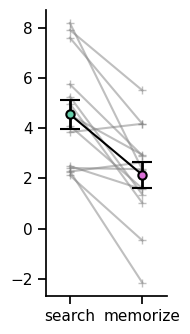

In [9]:
# plot of the average target width difference by conditions
sns.set_context("notebook",  font_scale=1)
fig, ax = plt.subplots(figsize=(2,3.5))
x = [0,.3]
y = [plotdf[plotdf["condition"]=='search']["prop_rx"].mean(),plotdf[plotdf["condition"]=='memorize']["prop_rx"].mean()]
error = [stats.sem(plotdf[plotdf["condition"]=='search']["prop_rx"]), stats.sem(plotdf[plotdf["condition"]=='memorize']["prop_rx"])]

for currim in plotdf.image_name.unique():
    currdf = plotdf.loc[plotdf['image_name']== currim]
    ax.plot(x, currdf['prop_rx'], linestyle="-",marker='+', markersize=6,markeredgewidth=1,  color='gray', 
             markeredgecolor="gray",  alpha=.5,linewidth=1.5,  markerfacecolor='none')
plt.plot([0,.3],[y[0],y[1]],linestyle="-",  color='black' )
plt.errorbar(0, y[0],
             yerr = error[0],  fmt='o', color='mediumaquamarine', 
           markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')
plt.errorbar(.3, y[1],
             yerr = error[1],  fmt='o', color='orchid', 
             markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')

ax.set_xticks([0,.3], labels=['search','memorize'])
ax.set_xlim([-.1, .4])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig(settings.RESULTS_PATH + '/figure7/7a.png', dpi=1000)

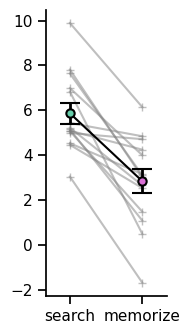

In [10]:
# plot of the average target height difference by conditions
sns.set_context("notebook",  font_scale=1)
fig, ax = plt.subplots(figsize=(2,3.5))
x = [0,.3]
y = [plotdf[plotdf["condition"]=='search']["prop_ry"].mean(),plotdf[plotdf["condition"]=='memorize']["prop_ry"].mean()]
error = [stats.sem(plotdf[plotdf["condition"]=='search']["prop_ry"]), stats.sem(plotdf[plotdf["condition"]=='memorize']["prop_ry"])]

for currim in plotdf.image_name.unique():
    currdf = plotdf.loc[plotdf['image_name']== currim]
    ax.plot(x, currdf['prop_ry'], linestyle="-",marker='+', markersize=6,markeredgewidth=1,  color='gray', 
             markeredgecolor="gray",  alpha=.5,linewidth=1.5,  markerfacecolor='none')
plt.plot([0,.3],[y[0],y[1]],linestyle="-",  color='black' )
plt.errorbar(0, y[0],
             yerr = error[0],  fmt='o', color='mediumaquamarine', 
           markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')
plt.errorbar(.3, y[1],
             yerr = error[1],  fmt='o', color='orchid', 
             markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')

ax.set_xticks([0,.3], labels=['search','memorize'])
ax.set_xlim([-.1, .4])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig(settings.RESULTS_PATH + '/figure7/7b.png', dpi=1000)

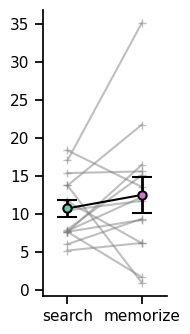

In [11]:
# plot of the average target x-axis displacement by conditions
sns.set_context("notebook",  font_scale=1)
fig, ax = plt.subplots(figsize=(2,3.5))
x = [0,.3]
y = [plotdf[plotdf["condition"]=='search']["prop_cx"].mean(),plotdf[plotdf["condition"]=='memorize']["prop_cx"].mean()]
error = [stats.sem(plotdf[plotdf["condition"]=='search']["prop_cx"]), stats.sem(plotdf[plotdf["condition"]=='memorize']["prop_cx"])]

for currim in plotdf.image_name.unique():
    currdf = plotdf.loc[plotdf['image_name']== currim]
    ax.plot(x, currdf['prop_cx'], linestyle="-",marker='+', markersize=6,markeredgewidth=1,  color='gray', 
             markeredgecolor="gray",  alpha=.5,linewidth=1.5,  markerfacecolor='none')

plt.plot([0,.3],[y[0],y[1]],linestyle="-",  color='black' )
plt.errorbar(0, y[0],
             yerr = error[0],  fmt='o', color='mediumaquamarine', 
           markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')
plt.errorbar(.3, y[1],
             yerr = error[1],  fmt='o', color='orchid', 
             markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')

ax.set_xticks([0,.3], labels=['search','memorize'])
ax.set_xlim([-.1, .4])
#ax.set_ylim([-.1, .4])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig(settings.RESULTS_PATH + '/figure7/7c.png', dpi=1000)

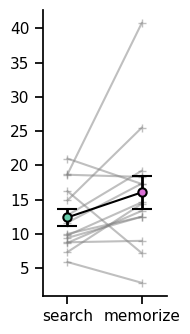

In [12]:
# plot of the average target y-axis displacement by conditions
sns.set_context("notebook",  font_scale=1)
fig, ax = plt.subplots(figsize=(2,3.5))
x = [0,.3]
y = [plotdf[plotdf["condition"]=='search']["prop_cy"].mean(),plotdf[plotdf["condition"]=='memorize']["prop_cy"].mean()]
error = [stats.sem(plotdf[plotdf["condition"]=='search']["prop_cy"]), stats.sem(plotdf[plotdf["condition"]=='memorize']["prop_cy"])]

for currim in plotdf.image_name.unique():
    currdf = plotdf.loc[plotdf['image_name']== currim]
    ax.plot(x, currdf['prop_cy'], linestyle="-",marker='+', markersize=6,markeredgewidth=1,  color='gray', 
             markeredgecolor="gray",  alpha=.5,linewidth=1.5,  markerfacecolor='none')
plt.plot([0,.3],[y[0],y[1]],linestyle="-",  color='black' )
plt.errorbar(0, y[0],
             yerr = error[0],  fmt='o', color='mediumaquamarine', 
           markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')
plt.errorbar(.3, y[1],
             yerr = error[1],  fmt='o', color='orchid', 
             markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')

ax.set_xticks([0,.3], labels=['search','memorize'])
ax.set_xlim([-.1, .4])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig(settings.RESULTS_PATH + '/figure7/7d.png', dpi=1000)

In [13]:
## circle plots
# shown the average drawn size and location by condition
for image_name in list_images(settings.IMG_PATH, '.png'):
    if image_name not in ['a-pr32', 'a-pr22', 'a-pr23']:
        target_search = adjusted_sizes.loc[(adjusted_sizes["image_name"] == image_name) & 
                                    (adjusted_sizes['identity']=='target') &
                                    (adjusted_sizes['condition']=='search')]
        target_mem = adjusted_sizes.loc[(adjusted_sizes["image_name"] == image_name) & 
                                    (adjusted_sizes['identity']=='target') &
                                    (adjusted_sizes['condition']=='memorize')]
        curr_im = plt.imread(str(settings.IMG_PATH) + '/' + image_name + '.png')
        plt.imshow(curr_im)

        # draw the ellipse
        ax = plt.gca()
        ax.add_patch(Ellipse((int(target_search['adj_cx'].mean()), 
                              int(target_search['adj_cy'].mean())), 
                             width=int(target_search['adj_rx'].mean()*2), 
                             height=int(target_search['adj_ry'].mean()*2),
                     edgecolor='mediumaquamarine',
                     facecolor='none',
                     linewidth=1))
        ax.add_patch(Ellipse((int(target_mem['adj_cx'].mean()), 
                              int(target_mem['adj_cy'].mean())), 
                             width=int(target_mem['adj_rx'].mean()*2), 
                             height=int(target_mem['adj_ry'].mean()*2),
                     edgecolor='orchid',
                     facecolor='none',
                    linestyle = '--',
                     linewidth=1))
     
        plt.axis('off')
        plt.savefig(str(settings.RESULTS_PATH + '/figure7/circleplots/' + image_name + '.svg'), dpi=1000)
        plt.clf() 
        
    if str(image_name) == 'a-pr23':
        curr_im = plt.imread(str(settings.IMG_PATH) + '/' + image_name + '.png')

        target_search = adjusted_sizes.loc[(adjusted_sizes["image_name"] == image_name) & 
                                    (adjusted_sizes['identity']=='target') &
                                    (adjusted_sizes['condition']=='search')]
            
        plt.imshow(curr_im)

        # draw the ellipse
        ax = plt.gca()
        ax.add_patch(Ellipse((int(target_search['adj_cx'].mean()), 
                              int(target_search['adj_cy'].mean())), 
                             width=int(target_search['adj_rx'].mean()*2), 
                             height=int(target_search['adj_ry'].mean()*2),
                     edgecolor='mediumaquamarine',
                     facecolor='none',
                     linewidth=1))
        
  
        plt.axis('off')
        plt.savefig(str(settings.RESULTS_PATH + '/figure7/circleplots/' + image_name + '.svg'), dpi=1000)
        plt.clf() 
        
    if str(image_name) == 'a-pr22':
        curr_im = plt.imread(str(settings.IMG_PATH) + '/' + image_name + '.png')

        target_search = adjusted_sizes.loc[(adjusted_sizes["image_name"] == image_name) & 
                                        (adjusted_sizes['identity']=='target') &
                                        (adjusted_sizes['condition']=='search')]
        target_mem = adjusted_sizes.loc[(adjusted_sizes["image_name"] == image_name) & 
                                        (adjusted_sizes['identity']=='target') &
                                        (adjusted_sizes['condition']=='memorize')]
        plt.imshow(curr_im)
        ax = plt.gca()
        ax.add_patch(Ellipse((int(target_search['adj_cx'].mean()), 
                              int(target_search['adj_cy'].mean())), 
                             width=int(target_search['adj_rx'].mean()*2), 
                             height=int(target_search['adj_ry'].mean()*2),
                     edgecolor='mediumaquamarine',
                     facecolor='none',
                     linewidth=1))
        ax.add_patch(Ellipse((int(target_mem['adj_cx'].mean()), 
                              int(target_mem['adj_cy'].mean())), 
                             width=int(target_mem['adj_rx'].mean()*2), 
                             height=int(target_mem['adj_ry'].mean()*2),
                     edgecolor='orchid',
                     facecolor='none',
                    linestyle = '--',
                     linewidth=1))
        
        plt.axis('off')
        plt.savefig(str(settings.RESULTS_PATH + '/figure7/circleplots/' + image_name + '.svg'), dpi=1000)
        plt.clf() 
        
        
    if str(image_name) == 'a-pr32':
        curr_im = plt.imread(str(settings.IMG_PATH) + '/' + image_name + '.png')
        target_search = adjusted_sizes.loc[(adjusted_sizes["image_name"] == image_name) & 
                                    (adjusted_sizes['identity']=='target') &
                                    (adjusted_sizes['condition']=='search')]
        target_mem = adjusted_sizes.loc[(adjusted_sizes["image_name"] == image_name) & 
                                        (adjusted_sizes['identity']=='target') &
                                        (adjusted_sizes['condition']=='memorize')]
        plt.imshow(curr_im)
        ax = plt.gca()
        ax.add_patch(Ellipse((int(target_search['adj_cx'].mean()), 
                              int(target_search['adj_cy'].mean())), 
                             width=int(target_search['adj_rx'].mean()*2), 
                             height=int(target_search['adj_ry'].mean()*2),
                     edgecolor='mediumaquamarine',
                     facecolor='none',
                     linewidth=1))
        
        plt.axis('off')
        plt.savefig(str(settings.RESULTS_PATH + '/figure7/circleplots/' + image_name + '.svg'), dpi=1000)
        plt.clf() 


<Figure size 640x480 with 0 Axes>